$ \huge{1.}$ \
Yes, it is possible for us to create a matrix $D^{k}$. It can be written as: \

\begin{bmatrix}
  \frac{1}{6144x_1^2 - 2048x_2 + 2 } & 0 \\ 0 & \frac{1}{1024} 
\end{bmatrix}

The diagonal elements in this matrix are approximately equal to the inverse of the eigenvalues of the Hessian matrix $Q(x)$.

In [2]:
import numpy as np

In [3]:
def evalh(x): 
  assert type(x) is np.ndarray 
  assert len(x) == 2
  return np.array([[6144*(x[0]**2)-2048*x[1]+2,-2048*x[0]],[-2048*x[0],1024]])

In [4]:
def find_condition_number(A):
  assert type(A) is np.ndarray
  assert A.shape[0] == A.shape[1]
  k=max(np.linalg.eig(A)[0])/min(np.linalg.eig(A)[0])
  return k

In [5]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  #compute and return D_k
  d_k = np.array([[1/evalh(x)[0][0], 0],[0, 1/evalh(x)[1][1]]])
  return d_k

In [6]:
#Now we will define a Python function which will compute and return the objective function value 
def evalf(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  #after checking if the argument is valid, we can compute the objective function value
  #compute the function value and return it 
  return (512*((x[1]-x[0]**2)**2)+ (4-x[0])**2)

In [7]:
def evalg(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  #after checking if the argument is valid, we can compute the gradient value
  #compute the gradient value and return it 
  return np.array([-2048*x[0]*(x[1]-x[0]**2)-2*(4-x[0]),1024*(x[1]-x[0]**2)])

In [8]:
#Complete the module to compute the steplength by using the closed-form expression
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  #Complete the code 
  alpha = alpha_start
  p_k = -gradf
  #implement the backtracking line search
  while evalf(x + alpha*p_k) > (evalf(x) + gamma*alpha*(np.dot(gradf.transpose(),p_k))):
    alpha = rho* alpha 
  return alpha

In [9]:
def compute_steplength_backtracking_scaled_direction(x, gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  alpha = alpha_start
  while evalf(x + alpha*direction) > ( evalf(x) +  (gamma*alpha*np.dot(gradf,direction)) ):
    alpha = rho*alpha
  return alpha

In [10]:
#line search type 
BACKTRACKING_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH_SCALING= 2
BACKTRACKING_LINE_SEARCH_Scaled=3

In [11]:
#complete the code for gradient descent to find the minimizer
def find_minimizer_gd(start_x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  
  #Complete the code   
  A = np.array([[1500, 2],[2,1]])
  x = start_x
  g_x = evalg(x)
  itr=[]
  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]
    #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)
  condition_num_arr = []
  k = 0
  #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance 
    condition_num_arr.append(find_condition_number(evalh(x)))
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking(x,g_x,alpha_start,rho,gamma)  
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here   
    x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    itr.append(k)
    #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
  return x ,evalf(x),k,condition_num_arr,itr

In [12]:
#complete the code for gradient descent with scaling to find the minimizer
def find_minimizer_gdscaling(start_x, tol, line_search_type,*args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  A = np.array([[1500, 2],[2,1]])
  x = start_x
  g_x = evalg(x)
  d_k = compute_D_k(x)
  #initialization for backtracking line search
  alpha_start = args[0]
  rho = args[1]
  gamma = args[2]
  #print('Params for Backtracking LS: alpha start:', alpha_start, 'rho:', rho,' gamma:', gamma)

  k = 0
  #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    direction = np.matmul(-d_k,g_x)
    if line_search_type == BACKTRACKING_LINE_SEARCH_SCALING:
      step_length = compute_steplength_backtracking_scaled_direction(x,g_x,direction,alpha_start,rho,gamma)
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here   
    x = np.subtract(x, np.matmul(np.multiply(step_length,g_x),d_k)) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point

    #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
  return x ,evalf(x),k

In [13]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5

In [14]:
#check gradient descent with backtracking line search 
alpha_start = 1.
rho = 0.5
gamma = 0.5
opt_x,f_x,itr,cndtn,itr_lst=find_minimizer_gd(my_start_x,my_tol,BACKTRACKING_LINE_SEARCH,alpha_start,rho,gamma)
print("Minimizer is",opt_x)
print("Function value at minimizer =",f_x)
print("Number of iterations is",itr)

Minimizer is [ 3.9999598  15.99967843]
Function value at minimizer = 1.615724753450513e-09
Number of iterations is 902336


In [15]:
#check gradient descent with scaling and backtracking line search 
alpha_start = 1.
rho = 0.5
gamma = 0.5
opt_x,f_x,itr=find_minimizer_gdscaling(my_start_x, my_tol,BACKTRACKING_LINE_SEARCH_SCALING ,alpha_start,rho,gamma)
print("Minimizer is ",opt_x)
print("Function value at minimizer =",f_x)
print("Number of iterations is",itr)

Minimizer is  [ 4.00000587 16.00004695]
Function value at minimizer = 3.443537447531682e-11
Number of iterations is 2918412


**Observations:** We can see that the number of iterations required to reach the minimizer using the Backtracking Line Search algorithm with scaling is much larger as compared to the number of iterations required in the 'without scaling' algorithm.

$ \huge{3.}$ \
Yes, matrix $Q$ can be identified. \
$Q = ((D^{k})^{1/2})^{T}A^{k}(D^{k})^{1/2}$ \
$A$ is the Hessian matrix of $f$ and\
$D^{k} = (∇^{2}f(x^{k}))^{-1}$ 

In [16]:
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  if np.linalg.det(evalh(x)) == 0:
    raise ValueError('Determinant does not exist. Please check!!')
  return np.linalg.inv(evalh(x))

In [17]:
#complete the code for gradient descent with scaling to find the minimizer
import scipy
from scipy.linalg import sqrtm
def find_minimizer_gdscaling_non_diagonal(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  x = start_x
  g_x = evalg(x)

  condition_number_scaling = []
  itr_lst_scaling = []

  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH_Scaled):
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

  k = 0
  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
    d_k = compute_D_k(x)
    direction = np.matmul(-d_k,g_x)
    
    p = scipy.linalg.sqrtm(d_k)
    hessn = np.matmul(np.matmul(p,evalh(x)),p)
    condition_number_scaling.append(find_condition_number(hessn))

    if line_search_type == BACKTRACKING_LINE_SEARCH_Scaled:
      step_length = compute_steplength_backtracking_scaled_direction(x, g_x,direction, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength 
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #implement the gradient descent steps here  
    x = np.subtract(x, np.multiply(step_length,np.matmul(d_k, g_x))) #update x = x - step_length*g_x
    k += 1 #increment iteration
    g_x = evalg(x) #compute gradient at new point
    itr_lst_scaling.append(k)

  return x, k, condition_number_scaling, evalf(x), itr_lst_scaling

In [18]:
my_start_x = np.array([8.0,8.0])
my_tol= 1e-5

In [19]:
#Compute gradient descent with scaling and with backtracking line search 

print("Gradient descent algorithm Backtracking Line Search(With scaling):")
#check what happens when you call find_minimzer using backtracking line search
x_opt_bls, k, condtn_num_scaling,f_val2, itr_scaled = find_minimizer_gdscaling_non_diagonal(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH_Scaled, 1.0, 0.5, 0.5)
print("Optimizer: ", x_opt_bls,'\nMinimum Value: ', f_val2, "\nNumber of iterations: ", k)

Gradient descent algorithm Backtracking Line Search(With scaling):
Optimizer:  [ 4. 16.] 
Minimum Value:  2.373469471365615e-25 
Number of iterations:  48


Gradient descent algorithm Backtracking Line Search(without scaling)

minimizer [ 3.9999598 15.99967843] minimum value 1.615724753450513e-09 number of iterations 902336

Gradient descent algorithm Backtracking Line Search(with scaling) using Newton method:

Optimizer: [ 4. 16.]

Minimum Value: 2.373469471365615e-25

Number of iterations: 48

Observations: Clealy, we can see that we got exact actual minimizer and minimum value of the function with very less number of iterations(only 48) using Newton's method as compared to without scaling technique, which implies that for such problems this Newton method is more useful than that of the previous one as it will give more accurate answers within less amount of time.

$ \huge{4.}$ \
\
**Backtracking Line Search without Scaling:** \
Minimizer = $(3.9999598, 15.99967843)$ \
Function value at minimizer = $1.61572475345051e-09$ \
Number of iterations required = $902336$ \
\
**Backtracking Line Search with Scaling (using Newton Method):** \
Minimizer = $(4, 16)$ \
Function value at minimizer = $2.373469471365615e-25$ \
Number of iterations required = $48$ \
\
**Observations:** Using the Line Search algorithm with scaling, using Newton Method, we observe that we are able to obtain the exact minimier value and consequently, the exact minimum value of the function. Through this, we can conclude that Newton Method is preferrable as it provides exact solutions in a very small amount of time (number of iterations required for the function in question was only 48). 

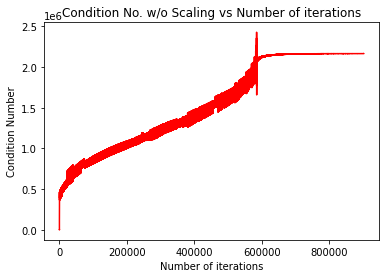

In [22]:
import matplotlib.pyplot as plt
plt.plot(itr_lst,cndtn,label ='Without Scaling', color ='red')
plt.xlabel('Number of iterations')
plt.ylabel('Condition Number')
plt.title("Condition No. w/o Scaling vs Number of iterations")
plt.show()

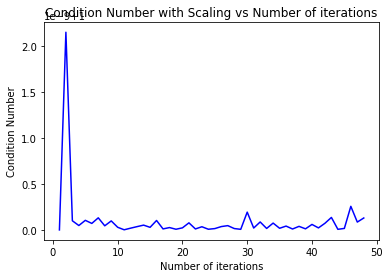

In [23]:
plt.plot( itr_scaled,condtn_num_scaling,label = 'With Scaling', color = 'blue')
plt.xlabel('Number of iterations')
plt.ylabel('Condition Number')
plt.title("Condition Number with Scaling vs Number of iterations")
plt.show()

In 'with scaling' method graph we can see that for iterations between 0-4(approx) condition number is sharply increasing and then sharply decreasing and then theere is a very slight variation visible in the value while in case of 'without scaling' condition number is increasingly almost linearly with number of iteration and becoming constant after 600000 iterations. So we can conclude that convergence of condition number comes faster in case of 'with scaling' than that of 'without scaling'.

**Observations:** We can see in the With Scaling graph that the condition number plot forms a huge spike when the number of iterations is between 0 and 4 approximately. Beyond this point, the fluctuations are comparatively small. \
In the Without Scaling graph, the condition number increases almost linearly with the number of iterations upto some value just below 600000, from where the values stay more or less constant even if the number of iterations are increased.